In [1]:
!pip install -q torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00


In [2]:
!pip install -q diffusers transformers accelerate

In [3]:
# Try installing libraries separately to avoid conflicts
!pip install -q opencv-python matplotlib
!pip install -q open3d
!pip install -q pythreejs trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.8/708.8 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 24.4 MB/s eta 0:00:00


In [4]:
import torch
from diffusers import StableDiffusionPipeline
import cv2
import numpy as np
import open3d as o3d
import trimesh
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
from pythreejs import *

In [5]:
def generate_image(prompt="a medieval fantasy helmet with horns"):
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

    image = pipe(prompt).images[0]
    image.save("generated.png")
    print("[✓] Image saved as generated.png")
    return "generated.png"


In [6]:
def generate_depth(image_path):
    model_type = "DPT_Hybrid"
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas = midas.to("cuda" if torch.cuda.is_available() else "cpu").eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img_rgb).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        prediction = midas(input_batch)
        depth = prediction.squeeze().cpu().numpy()

    depth = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
    depth_img = depth.astype(np.uint8)

    depth_resized = cv2.resize(depth_img, (img.shape[1], img.shape[0]))
    cv2.imwrite("depth.png", depth_resized)
    print("[✓] Depth map saved as depth.png")
    return "depth.png"

In [7]:
def simulate_multiview_mesh(rgb_path, depth_path, output_path="fused_mesh.obj", num_views=12):
    print(f"[🔄] Generating mesh using {num_views} simulated views...")
    rgb = cv2.imread(rgb_path)
    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)

    h, w = depth.shape
    fx = fy = 500.0
    cx, cy = w // 2, h // 2

    color_raw = o3d.geometry.Image(rgb)
    depth_raw = o3d.geometry.Image(depth)

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_raw, depth_raw, depth_scale=1.0, depth_trunc=255.0, convert_rgb_to_intensity=False
    )

    intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)
    base_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)

    base_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5.0, max_nn=30))
    all_pcds = [base_pcd]

    for i in range(1, num_views):
        angle = (2 * np.pi / num_views) * i
        R = base_pcd.get_rotation_matrix_from_axis_angle([0, angle, 0])
        pcd_rotated = base_pcd.rotate(R, center=(0, 0, 0))
        all_pcds.append(pcd_rotated)

    print(f"[🌀] Simulated {num_views} views.")
    merged_pcd = all_pcds[0]
    for pcd in all_pcds[1:]:
        merged_pcd += pcd

    print("[🧠] Merged all simulated views. Running surface reconstruction...")
    merged_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5.0, max_nn=30))
    mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(merged_pcd, depth=9)
    mesh.compute_vertex_normals()

    o3d.io.write_triangle_mesh(output_path, mesh)
    print(f"[✓] Final multiview mesh saved as {output_path}")

In [8]:
prompt = "a medieval fantasy helmet with horns"
rgb = generate_image(prompt)
depth = generate_depth(rgb)
simulate_multiview_mesh(rgb, depth, output_path="fused_mesh.obj", num_views=8)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[✓] Image saved as generated.png


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

[✓] Depth map saved as depth.png
[🔄] Generating mesh using 8 simulated views...
[🌀] Simulated 8 views.
[🧠] Merged all simulated views. Running surface reconstruction...
[Open3D WARNING] Write OBJ can not include triangle normals.
[✓] Final multiview mesh saved as fused_mesh.obj


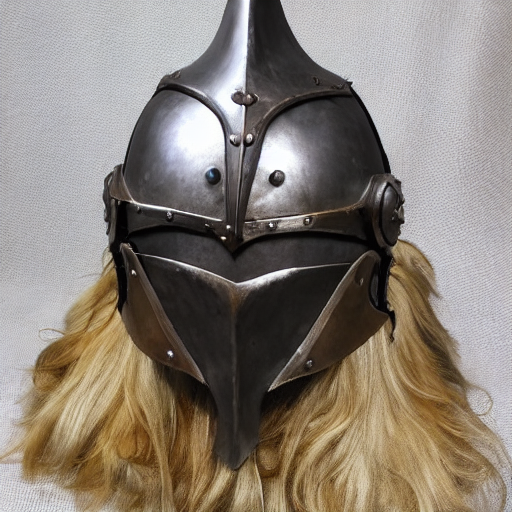

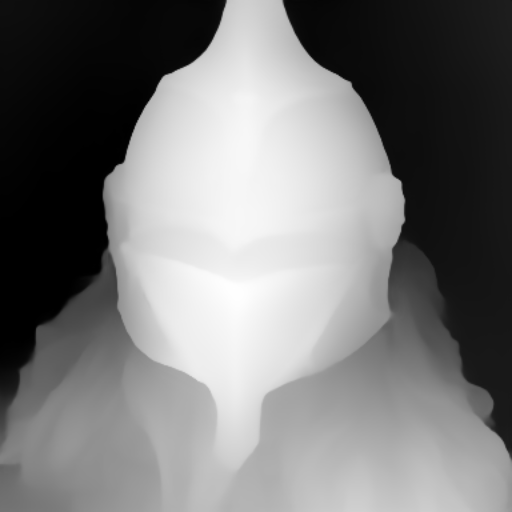

In [9]:
display(Image.open("generated.png"))
display(Image.open("depth.png"))

In [10]:
def show_mesh(filepath="fused_mesh.obj"):
    mesh = trimesh.load(filepath)
    if isinstance(mesh, trimesh.Scene):
        mesh = mesh.dump(concatenate=True)

    geometry = BufferGeometry(
        attributes={
            "position": BufferAttribute(mesh.vertices.astype(np.float32), normalized=False),
            "index": BufferAttribute(mesh.faces.astype(np.uint32).flatten(), normalized=False)
        }
    )
    material = MeshStandardMaterial(color='orange', metalness=0.2, roughness=0.6)
    mesh_obj = Mesh(geometry=geometry, material=material)

    camera = PerspectiveCamera(position=[2, 2, 2], fov=75,
                               children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.6)])
    scene = Scene(children=[mesh_obj, camera, AmbientLight(intensity=0.5)],
                  background="#aaaaaa")

    renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)],
                        width=640, height=480)
    display(renderer)


show_mesh("fused_mesh.obj")

/usr/local/lib/python3.11/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.0, 5.0,…